In [319]:
import tensorflow as tf 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [304]:
def generator(z, Output_dimension, n_units, reuse, alpha):
    with tf.variable_scope('generator', reuse=reuse):
        # creat a variable scope to save the variable under the 'generator' variable list  
        H_layer1=tf.layers.dense(z, n_units, activation=None,name='G_dense_1')
        # hidden layer: input is latent variable, number of units= 128
        H_layer1=tf.maximum(H_layer1, alpha*H_layer1)
        # this maximum combine with dense layer can realize the Leaky ReLU 
        # alpha is a parameter which is less than 1
        logits=tf.layers.dense(H_layer1, Output_dimension, activation=None,name='G_dense_2')
        # logits layer:Output dimension=724 
        Out=tf.nn.tanh(logits)
        # output is rescaled into between -1 to 1 
        return Out, logits

In [305]:
def discriminator(x, n_units, reuse, alpha):
    with tf.variable_scope('discriminator',reuse=reuse):
        # creat a variable scope to save the variable under the 'discriminator' variable list
        H_layer1=tf.layers.dense(x,n_units,activation=None,name='D_dense_1')
        # Hidden layer: input is the images to be discriminated, number of units=128
        H_layer1=tf.maximum(H_layer1,alpha*H_layer1)
        # smae as generator: creat the operation as Leaky ReLU
        logits=tf.layers.dense(H_layer1,1,activation=None,name='D_dense_2')
        # logits layer: output dimension is 1
        Out=tf.nn.sigmoid(logits)
        # output value: when it is close to 1, it will be treated as the real image, vice versa.
        return Out, logits
    

In [313]:
tf.reset_default_graph()# reset the default graph 
z=tf.placeholder(tf.float32,(None,100),name='z')
# creat placeholder for input latent variable z, dimension=[batch size, 100]
real_image=tf.placeholder(tf.float32,(None,784),name='real_image')
# creat placeholder for the real trainging data, dimension= [batch size, 724] 

In [314]:
# initial input parameter set here
Output_dimension=784
n_units=128
alpha=0.01
smooth=0.1
learning_rate=0.002

In [315]:
# creat generator network 
g_out,g_logits=generator(z,Output_dimension,n_units,False,alpha)
# creat discriminator network
d_out_real,d_logits_real=discriminator(real_image,n_units,False,alpha)
d_out_fake,d_logits_fake=discriminator(g_out,n_units,True,alpha)

In [316]:
# loss funtion goes here 
# firstly label the real image from the training data by 1 and fake image from the generetor by 0
# In order toreduce overfitting, use the label smoothing method here: it prevents a network
#from assigning full probability to each training example and maintains a reasonable ratio between
# the logits of the incorrect classes. 
#And from the experiment result of this paper smooth=0.1 always perform well
real_label=tf.ones_like(d_logits_real)*(1-smooth)
fake_label=tf.zeros_like(d_logits_fake)
# discriminator loss funtion 
d_loss_real=tf.nn.sigmoid_cross_entropy_with_logits(labels=real_label,logits=d_logits_real)
d_loss_fake=tf.nn.sigmoid_cross_entropy_with_logits(labels=fake_label,logits=d_logits_fake)
# here uing the sigmoid_cross_entropy, causing the label is between 0 to 1.
# discriminator loss funtion is that training the discriminator to assign the right label to real
# image 1 and to fake image 0 as precisely as possible
d_loss=tf.reduce_mean(d_loss_real+d_loss_fake)# total loss is the summation of both two parts
g_loss=tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_fake),
                                                              logits=d_logits_fake))
# generator loss funtion is that training the generator to generator fake images that are more like 
# real ones, that is the labels are close to 1.

In [317]:
# define the optimizer
# In order to train the generator and discriminator seperately, seperate the variable of 
# discriminator and generator into two parts g_var and d_var
var= tf.trainable_variables()
g_vars = [var for var in var if var.name.startswith("generator")]
d_vars = [var for var in var if var.name.startswith("discriminator")]

# then define the discriminator here.
# in order to compare different optimizer, use different optimizers here
d_train_op_adam=tf.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
g_train_op_adam=tf.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

d_train_op_SGD=tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)

g_train_op_SGD=tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

In [318]:
# training the model 
batch_size=100# batch size is 100
epochs=100 # number of epochs =100
sample=[] # creat a empty list space to save the samples from the generator in each epoch 
loss=[]# creat a empty list space to save the loss function value during the optimization history
saver= tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            real_batch=batch[0].reshape((batch_size,784))
            #here rescale the input real image from 0-1 to -1 to 1 
            real_batch=real_batch*2-1
            latent = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # run optimizer 
            _ = sess.run(d_train_op_adam, feed_dict={real_image: real_batch, z: latent})
            _ = sess.run(g_train_op_adam, feed_dict={z: latent})
        # after each epoch, save the loss funtion value in to the loss[]
        d_save_loss=sess.run(d_loss,feed_dict={real_image: real_batch, z: latent})
        g_save_loss=sess.run(g_loss,feed_dict={z: latent})
        print("Epoch {0}/{1}...".format(i+1, epochs),
              "Discriminator Loss: {:.4f}...".format(d_save_loss),
              "Generator Loss: {:.4f}".format(g_save_loss))    
        loss.append((d_save_loss,g_save_loss))
        save_path = saver.save(sess, "/Applications/GAN/generator")
            
            
            
            


Epoch 1/100... Discriminator Loss: 0.3613... Generator Loss: 4.1232
Epoch 2/100... Discriminator Loss: 0.4546... Generator Loss: 2.3163
Epoch 3/100... Discriminator Loss: 0.3702... Generator Loss: 4.0906
Epoch 4/100... Discriminator Loss: 0.4114... Generator Loss: 3.6087
Epoch 5/100... Discriminator Loss: 1.1634... Generator Loss: 2.6437
Epoch 6/100... Discriminator Loss: 1.2511... Generator Loss: 3.4316
Epoch 7/100... Discriminator Loss: 1.2599... Generator Loss: 3.7388
Epoch 8/100... Discriminator Loss: 1.3425... Generator Loss: 2.4688
Epoch 9/100... Discriminator Loss: 1.3261... Generator Loss: 2.4488
Epoch 10/100... Discriminator Loss: 1.1965... Generator Loss: 1.9865
Epoch 11/100... Discriminator Loss: 1.0330... Generator Loss: 2.1743
Epoch 12/100... Discriminator Loss: 1.1635... Generator Loss: 1.4424
Epoch 13/100... Discriminator Loss: 1.5539... Generator Loss: 2.0831
Epoch 14/100... Discriminator Loss: 1.3351... Generator Loss: 1.5544
Epoch 15/100... Discriminator Loss: 1.2762.

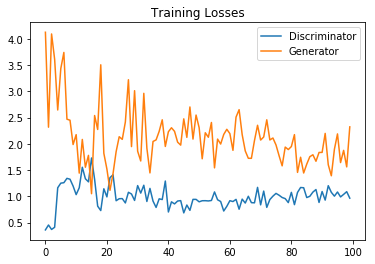

In [324]:
fig, ax = plt.subplots()
loss = np.array(loss)
plt.plot(loss.T[0], label='Discriminator')
plt.plot(loss.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()